# NLP Project

In [1]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

## Download of the Dataset

In [2]:
from utils.seeder import set_random_seed
SEED = 42

set_random_seed(SEED)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from utils.dataset_builder import get_dataframes

arguments_train_df, labels_train_df = get_dataframes('data', 'training')
arguments_test_df, labels_test_df = get_dataframes('data', 'validation')

In [4]:
print('Arguments dataframe structure:')
arguments_train_df.head()

Arguments dataframe structure:


Conclusion       Stance  \
0                  We should ban human cloning  in favor of   
1                      We should ban fast food  in favor of   
2  We should end the use of economic sanctions      against   
3         We should abolish capital punishment      against   
4                We should ban factory farming      against   

                                             Premise  \
0  we should ban human cloning as it will only ca...   
1  fast food should be banned because it is reall...   
2  sometimes economic sanctions are the only thin...   
3  capital punishment is sometimes the only optio...   
4  factory farming allows for the production of c...   

                                              Labels  
0                               [Security: societal]  
1                               [Security: personal]  
2             [Power: dominance, Security: societal]  
3  [Security: societal, Conformity: rules, Univer...  
4  [Security: personal, Benevolence: caring, Univ...

In [5]:
print('Labels dataframe structure:')
labels_train_df.head()

Labels dataframe structure:


Self-direction: thought  Self-direction: action  Stimulation  Hedonism  \
0                        0                       0            0         0   
1                        0                       0            0         0   
2                        0                       0            0         0   
3                        0                       0            0         0   
4                        0                       0            0         0   

   Achievement  Power: dominance  Power: resources  Face  Security: personal  \
0            0                 0                 0     0                   0   
1            0                 0                 0     0                   1   
2            0                 1                 0     0                   0   
3            0                 0                 0     0                   0   
4            0                 0                 0     0                   1   

   Security: societal  Tradition  Conformity: rules  \
0                   1          0                  0   
1                   0          0                  0   
2                   1          0                  0   
3                   1          0                  1   
4                   0          0                  0   

   Conformity: interpersonal  Humility  Benevolence: caring  \
0                          0         0                    0   
1                          0         0                    0   
2                          0         0                    0   
3                          0         0                    0   
4                          0         0                    1   

   Benevolence: dependability  Universalism: concern  Universalism: nature  \
0                           0                      0                     0   
1                           0                      0                     0   
2                           0                      0                     0   
3                           0                      1                     0   
4                           0                      1                     0   

   Universalism: tolerance  Universalism: objectivity  
0                        0                          0  
1                        0                          0  
2                        0                          0  
3                        0                          0  
4                        0                          0

In [6]:
print(f'Number of rows of the train dataframe: {len(arguments_train_df)}')
print(f'Number of rows of the test dataframe: {len(arguments_test_df)}')

Number of rows of the train dataframe: 5393
Number of rows of the test dataframe: 1896


In [7]:
TARGETS = labels_train_df.columns.to_list()

In [8]:
print(f'Number of classes: {len(TARGETS)}')

Number of classes: 20


In [9]:
from utils.dataset_builder import split_dataframes

(arguments_train_df, labels_train_df), (arguments_val_df, labels_val_df) = split_dataframes(
    arguments_train_df, labels_train_df, seed=SEED)

In [10]:
print(f'Number of rows of the train dataframe after splitting: {len(arguments_train_df)}')
print(f'Number of rows of the validation dataframe after splitting: {len(arguments_val_df)}')

Number of rows of the train dataframe after splitting: 4314
Number of rows of the validation dataframe after splitting: 1079


# Data Analysis

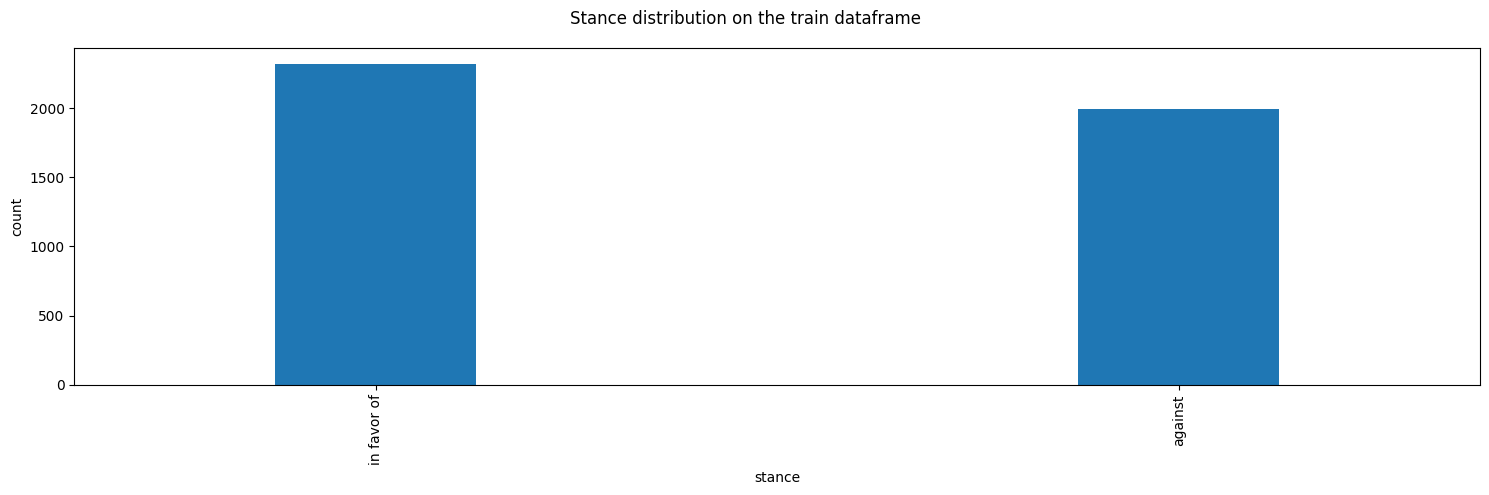

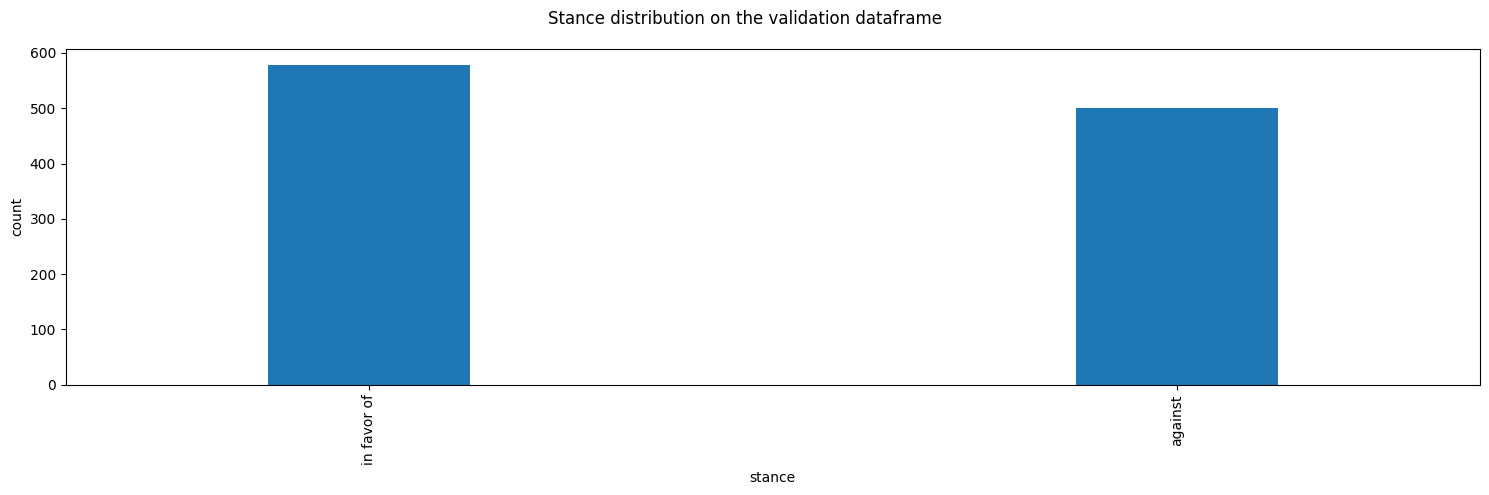

In [11]:
from utils.dataset_analysis import plot_stance_distribution

plot_stance_distribution(arguments_train_df, title='Stance distribution on the train dataframe')
plot_stance_distribution(arguments_val_df, title='Stance distribution on the validation dataframe')

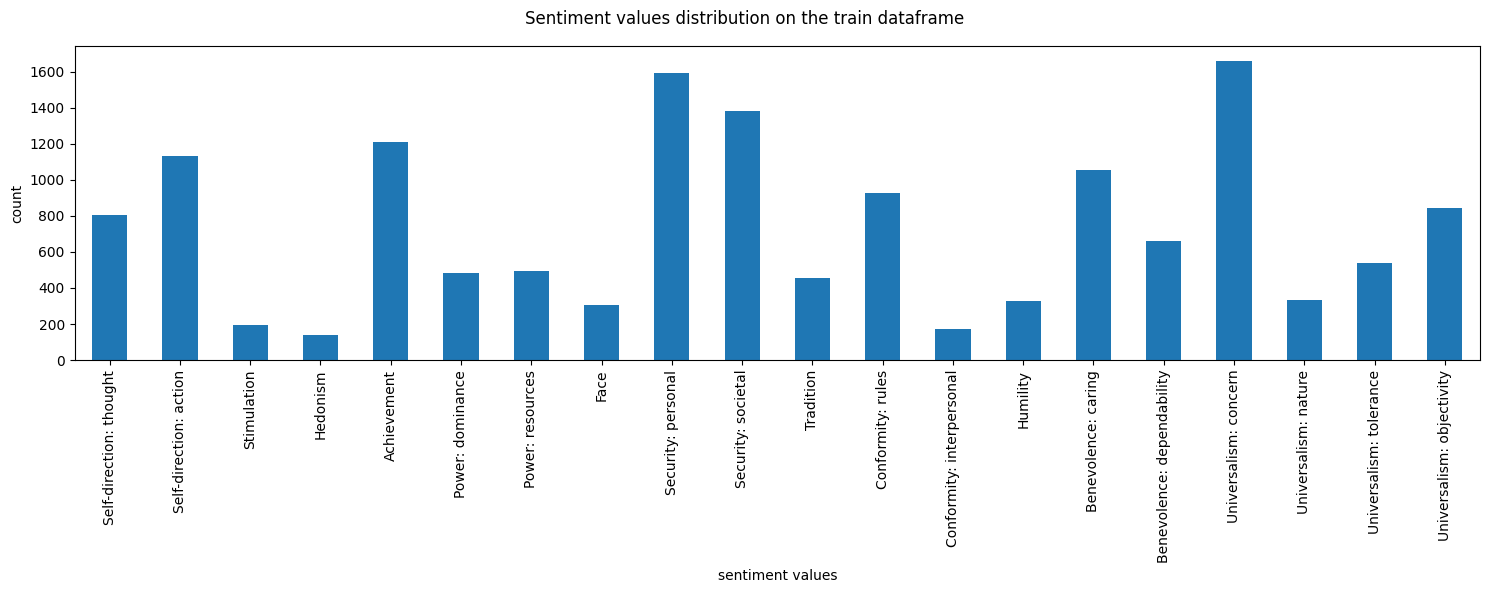

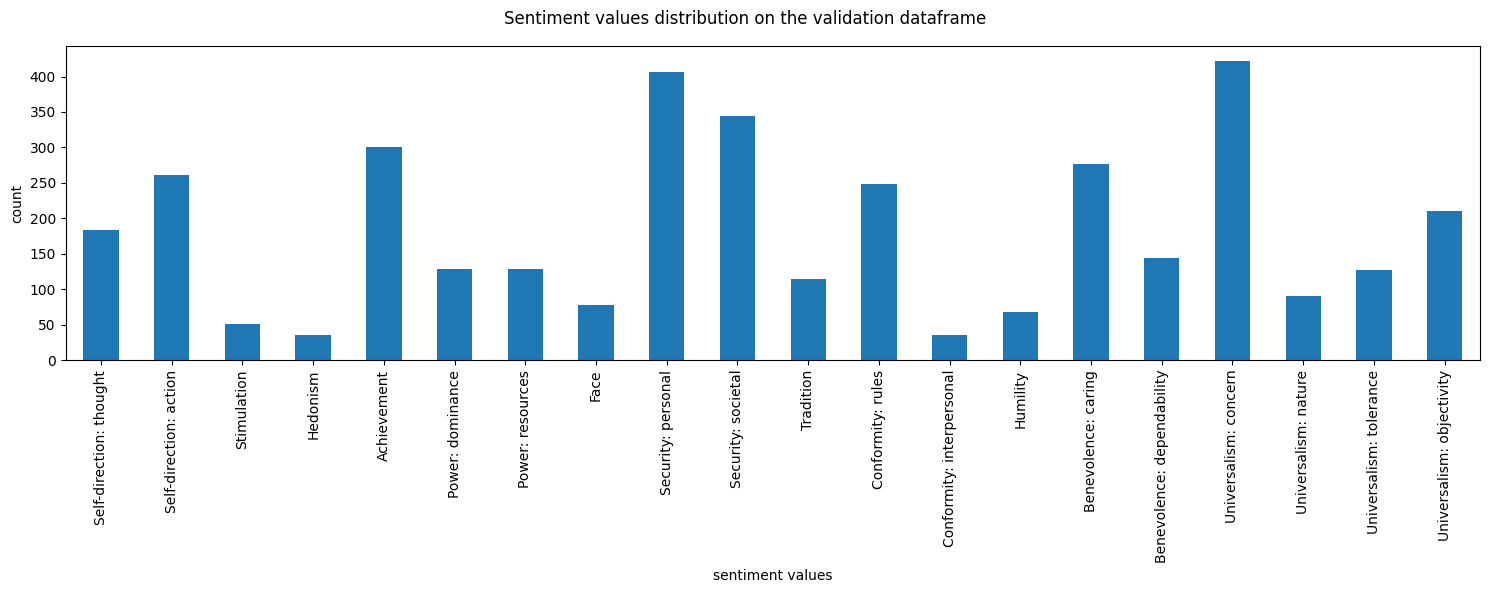

In [12]:
from utils.dataset_analysis import plot_sentiment_distribution

plot_sentiment_distribution(labels_train_df, title='Sentiment values distribution on the train dataframe')
plot_sentiment_distribution(labels_val_df, title='Sentiment values distribution on the validation dataframe')

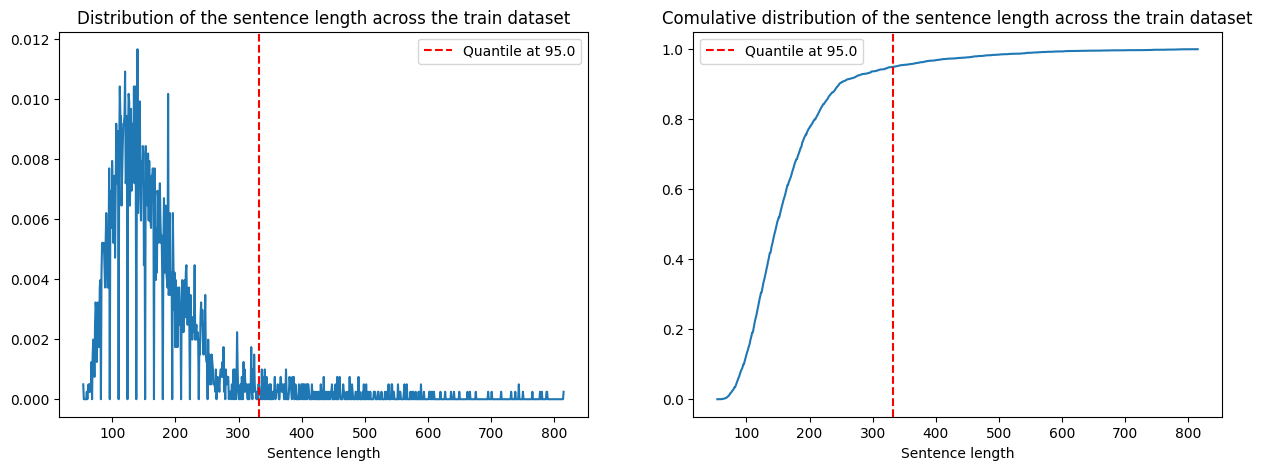

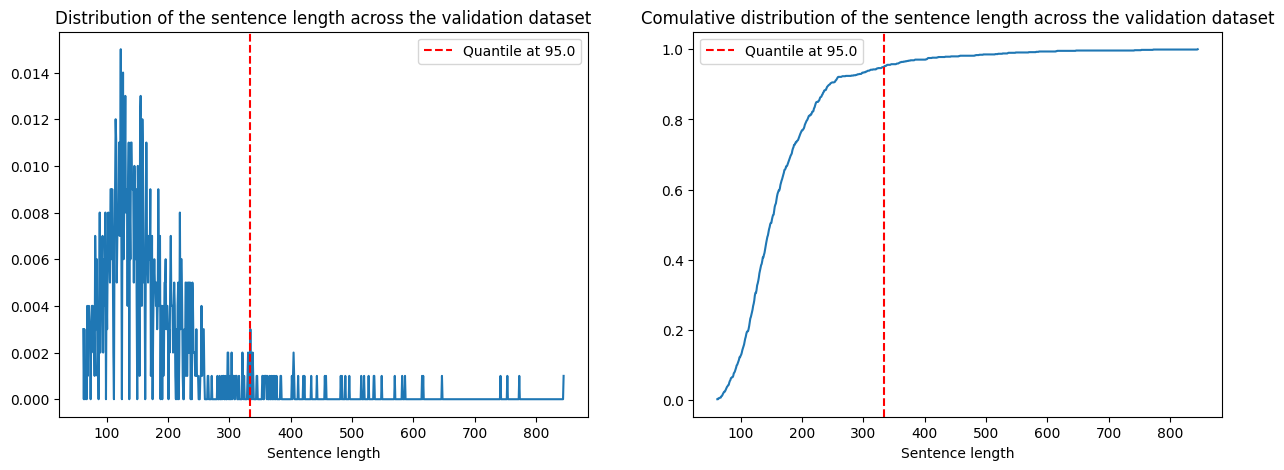

In [13]:
from utils.dataset_analysis import plot_sequence_length_analysis

plot_sequence_length_analysis(arguments_train_df, df_name='train dataset', percentile=.95)
plot_sequence_length_analysis(arguments_val_df, df_name='validation dataset', percentile=.95)

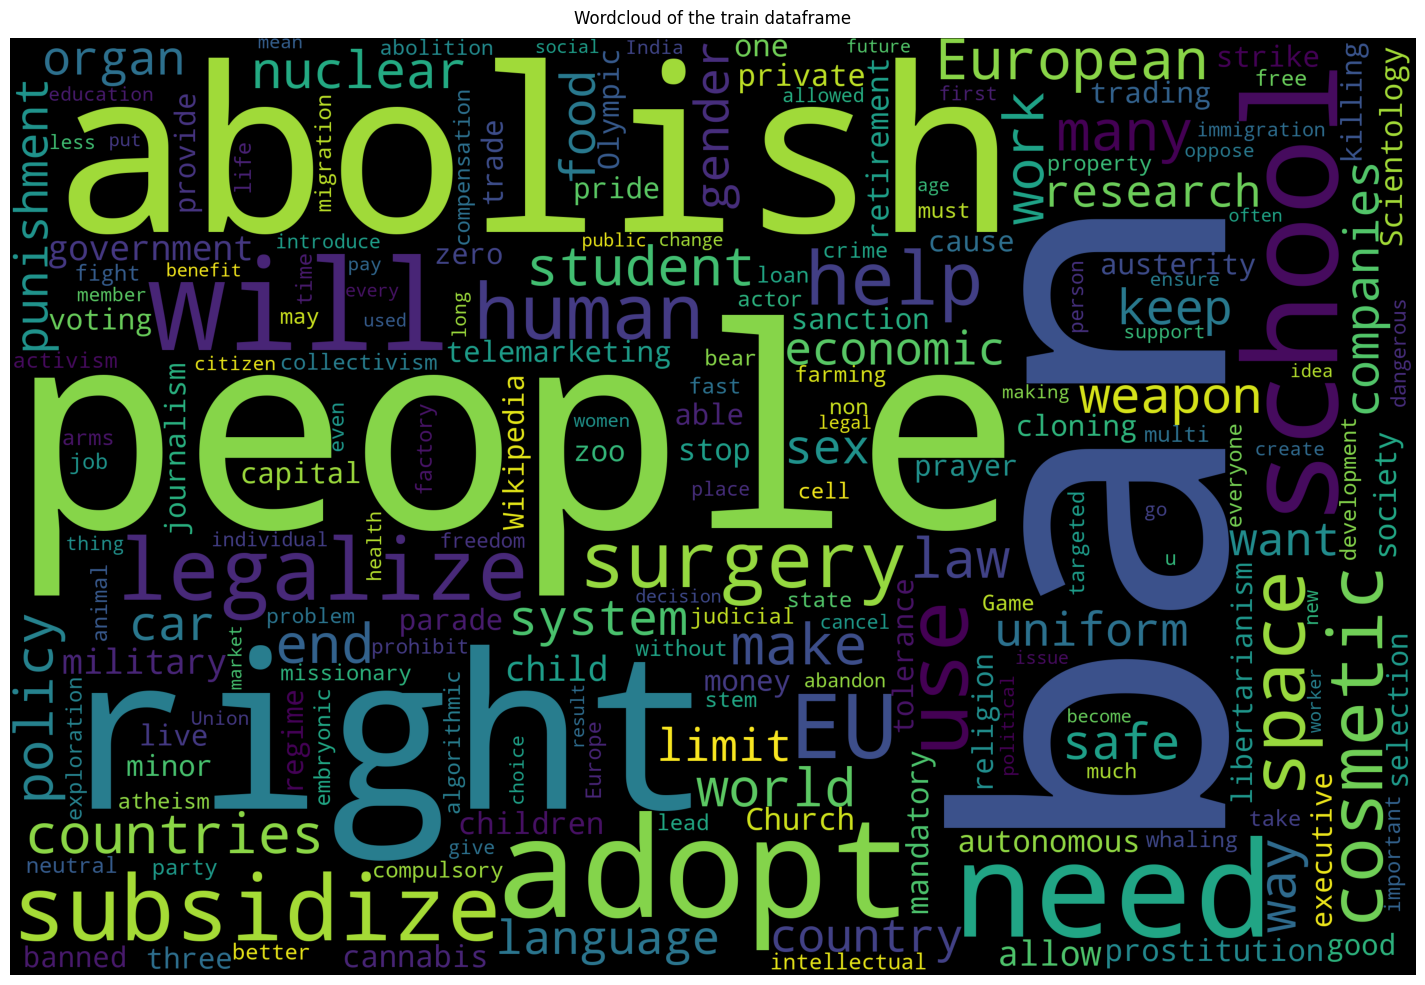

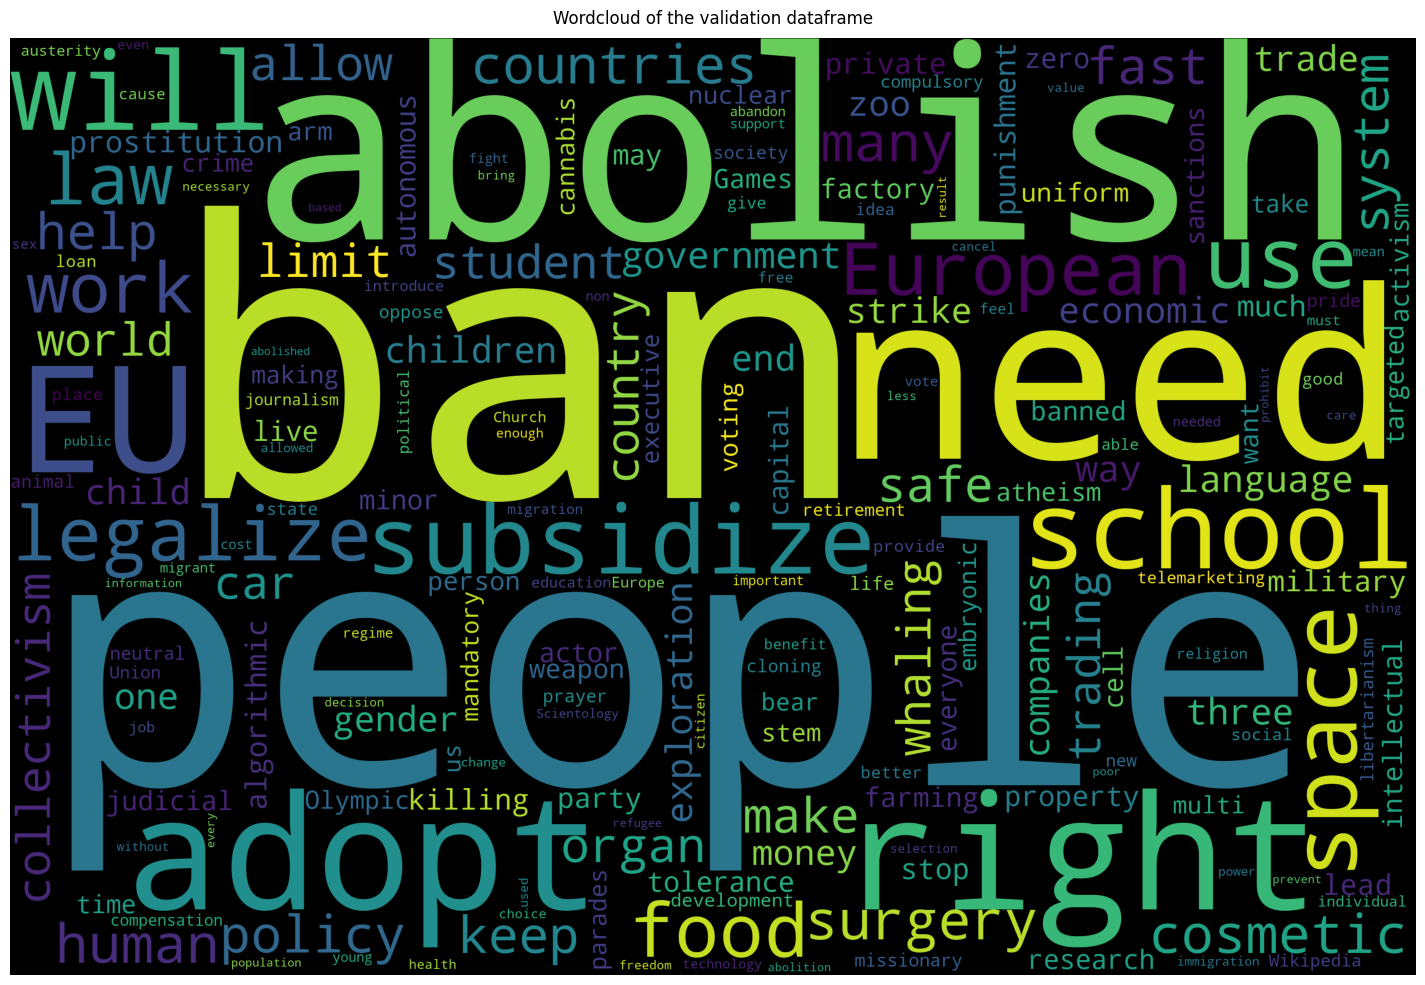

In [14]:
from utils.dataset_analysis import plot_word_cloud

plot_word_cloud(arguments_train_df, title='Wordcloud of the train dataframe')
plot_word_cloud(arguments_val_df, title='Wordcloud of the validation dataframe')

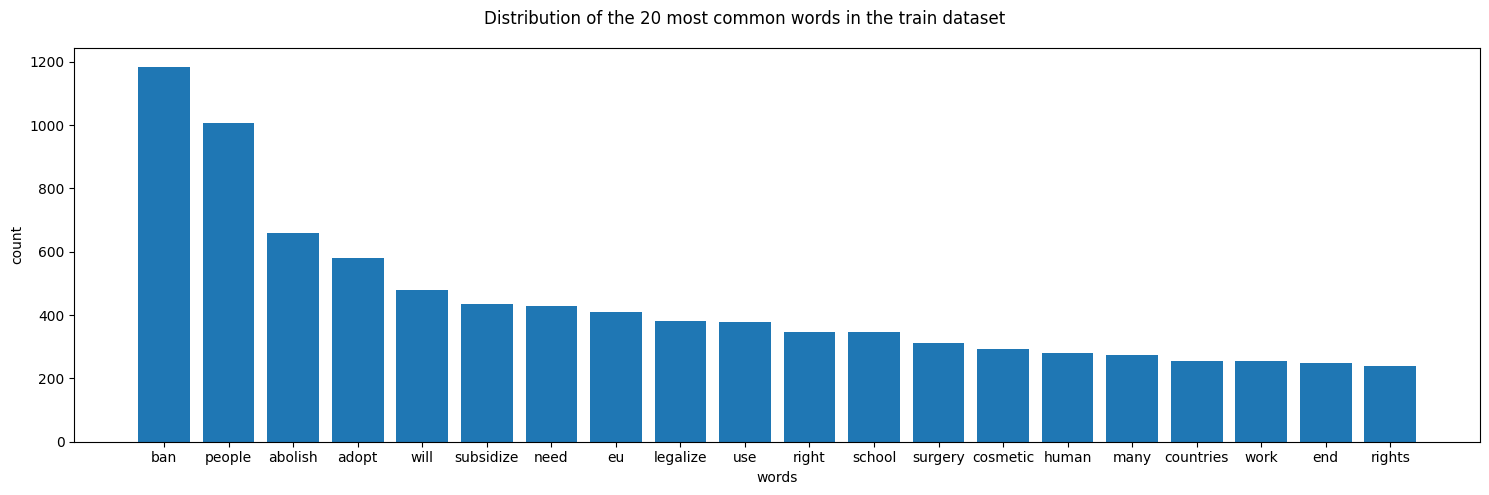

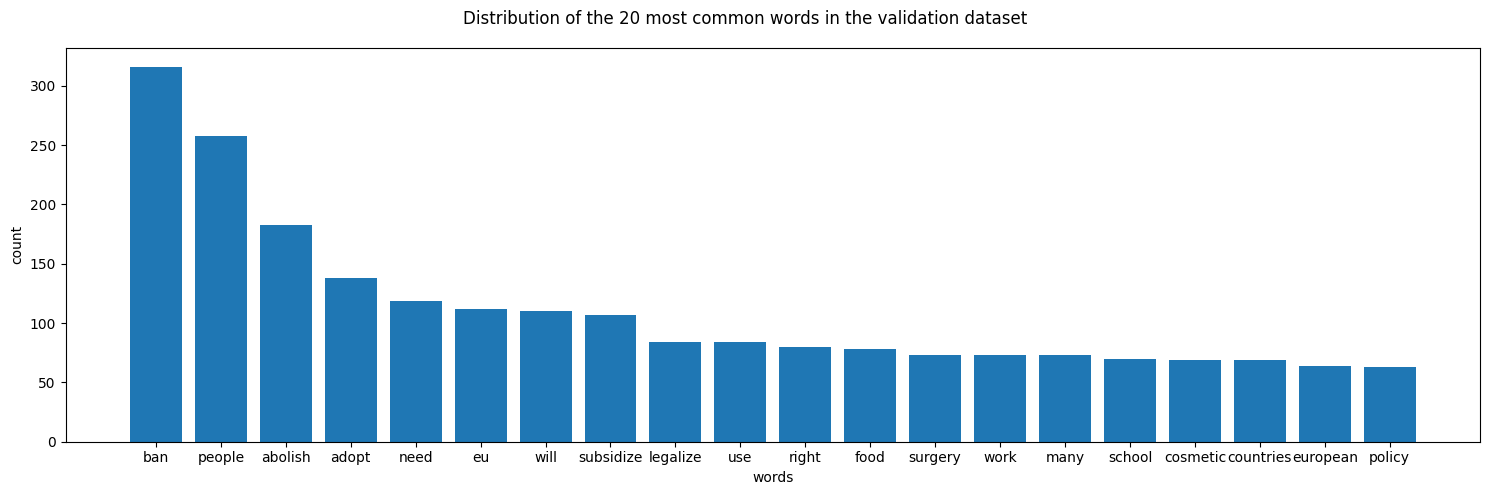

In [15]:
from utils.dataset_analysis import plot_most_common_words_distribution

plot_most_common_words_distribution(arguments_train_df, n=20,
                                    title='Distribution of the 20 most common words in the train dataset')
plot_most_common_words_distribution(arguments_val_df, n=20,
                                    title='Distribution of the 20 most common words in the validation dataset')

# Model and Tokenizer Definition

In [16]:
from torch import cuda
from transformers import logging

MODEL_NAME = 'roberta-base'
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set verbosity at "error" level
logging.set_verbosity_error()

In [17]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, problem_type='multi_label_classification')
tokenizer.add_tokens(['[FAV]', '[AGN]'], special_tokens=True)

stance_encoder = {'in favor of': '[FAV]', 'against': '[AGN]'}

In [18]:
from models.main_model import get_main_model

model = get_main_model(MODEL_NAME, num_labels=len(TARGETS), tokenizer=tokenizer, device=DEVICE)

In [19]:
print('Model structure:')
print(model)

Model structure:
RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50267, 768)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Laye

## Training

### Create Dataloaders

In [20]:
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE_BASE = 1e-05
LEARNING_RATE_HEAD = 1e-03

In [21]:
from utils.dataloader_builder import get_dataloader

train_loader = get_dataloader(arguments_train_df, labels_train_df, tokenizer, batch_size=8,
                   shuffle=True, use_augmentation=True)
val_loader = get_dataloader(arguments_val_df, labels_val_df, tokenizer, batch_size=16,
                   shuffle=False, use_augmentation=False)
test_loader = get_dataloader(arguments_test_df, labels_test_df, tokenizer, batch_size=16,
                   shuffle=False, use_augmentation=False)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=1):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma

    def forward(self, inputs, targets):
        #train_labels_frequencies
        # bce_loss = F.binary_cross_entropy_with_logits(inputs,  targets.float())
        alpha = self.alpha.to(inputs.device)
        
        probs = inputs.sigmoid()
        
        p_t = targets * probs + (1 - targets) * (1 - probs)
        alpha_t = targets * (1 - alpha) + (1 - targets) * alpha
        
        loss = - alpha_t * (1 - p_t) ** self.gamma * torch.log(p_t)

        return loss.mean()

In [23]:
train_labels_frequencies = (labels_train_df.sum() / len(labels_train_df)).to_numpy()

In [24]:

# Creating the loss function and optimizer
#loss_function = torch.nn.BCEWithLogitsLoss()
loss_function = FocalLoss(train_labels_frequencies, gamma=1.5)
optimizer = torch.optim.Adam(params=[
                {'params': model.roberta.parameters(), 'lr': LEARNING_RATE_BASE},
                {'params': model.classifier.parameters(), 'lr': LEARNING_RATE_HEAD}
            ])

In [25]:
# Function to calcuate the accuracy of the model
'''
def calculate_accuracy(out, targets, threshold=.5):
    out = out.sigmoid()
    return ((out > threshold) == targets.bool()).float().mean().item()'''

'\ndef calculate_accuracy(out, targets, threshold=.5):\n    out = out.sigmoid()\n    return ((out > threshold) == targets.bool()).float().mean().item()'

In [26]:
import os
from typing import Optional
from transformers import AutoModelForSequenceClassification

class Checkpoint():
    def __init__(self, model: AutoModelForSequenceClassification, path: Optional[str] = None) -> None:
        self.model = model
        self.last_metric = .0
        self.path = path if path is not None else os.path.join('checkpoints', 'best_model.pth')

        os.makedirs(os.path.dirname(self.path), exist_ok=True)

    def save_best(self, new_metric: float, **kwargs) -> None:
        #print(self.model.state_dict())
        if new_metric > self.last_metric:
            checkpoint = { k: np.array(v) for k, v in kwargs.items()}
            checkpoint['model_state_dict'] = self.model.state_dict(),

            torch.save(checkpoint, self.path)

        self.last_metric = new_metric
    
    def load_best(self) -> None:
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'][0])


In [27]:
class EarlyStopping():
    def __init__(self, patience=5, tolerance=.5) -> None:
        self.patience = patience
        self.tolerance = tolerance
        self.trigger_times = 0
        self.max_metric = 0.
        self.stop_condition = False

    def update(self, metric: float):
        if self.max_metric - metric <= self.tolerance:
            self.trigger_times = 0
            if metric > self.max_metric:
                self.max_metric = metric
        else:
            self.trigger_times += 1

            if self.trigger_times >= self.patience:
                self.stop_condition = True

    def is_stop_condition_met(self):
        return self.stop_condition


In [28]:
from IPython.display import DisplayHandle
import os
import sys
from time import time
from transformers import AutoModelForSequenceClassification
from typing import Optional
from sklearn.metrics import f1_score

import numpy as np
from torch.utils.data import DataLoader

device = DEVICE

'''def get_dataset_predictons(dataloader: DataLoader):
    predictions = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    true_labels = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    
    for batch_idx, data in enumerate(dataloader, 0):
        # Get the data
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
    
        # Compute output
        outputs = model(ids, mask)
        
        #results = outputs.logits.sigmoid()
        results = outputs.logits > 0
        results = results.cpu().numpy()
        results = results.astype(np.uint8)
        
        predictions = np.concatenate((predictions, results), axis=0)
        
        targets = data['labels'].cpu().numpy().astype(np.uint8)
        true_labels = np.concatenate((true_labels, targets), axis=0)
        
        #print(results)
        #print(targets.cpu().numpy().astype(np.uint8))
    return predictions, true_labels'''
    
def get_dataset_predictons(dataloader: DataLoader):
    predictions = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    true_labels = np.empty(shape=(0, len(labels_test_df.columns)), dtype=np.uint8)
    
    for batch_idx, data in enumerate(dataloader, 0):
        with torch.no_grad():
            # Get the data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
        
            # Compute output
            outputs = model(ids, mask)

            preds = outputs.logits
            
            preds = preds.cpu().numpy()
            
            predictions = np.concatenate((predictions, preds), axis=0)

            targets = data['labels'].cpu().numpy().astype(np.uint8)
            true_labels = np.concatenate((true_labels, targets), axis=0)

    return predictions, true_labels

def _loss_validate(val_dataloader: DataLoader, print_result: bool = True):
    print()
    # disp = display('', display_id=True)

    # Variables for accumulating the loss1 and loss2
    running_loss = .0
    running_accuracy = .0

    # Number of evaluated samples
    batch_step = 0

    # Starting time
    start_time = time()

    torch.cuda.empty_cache()

    preds, y_true = get_dataset_predictons(val_dataloader)
    
    loss = loss_function(torch.Tensor(preds).to(device, dtype=torch.float32),
                         torch.Tensor(y_true).to(device, dtype=torch.float32))
    
    y_pred = preds > 0
    y_pred = y_pred.astype(np.uint8)

    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')

    
    final_time = time() - start_time
    
    if print_result:
        print(
            f'validate: ' +
            f'{final_time:.0f}s, ' +
            f'validation loss: {loss:.3g}, '
            f'validation f1 macro: {f1_macro * 100:.3g} %' +
            '               '
            )

    return loss, f1_macro



def train(train_dataloader: DataLoader, val_dataloader: DataLoader, model: AutoModelForSequenceClassification, 
          epochs: int = 5, steps_validate: int = 100, checkpoint_path: Optional[str] = None,
          reload_best_weights: bool = True) -> None:

    checkpoint = Checkpoint(model, checkpoint_path)
    # Create path to save checkpoints
    '''if checkpoint_path is None:
        checkpoint_path = os.path.join('checkpoints', 'checkpoints.pth')''';

    #os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
    
    early_stopping = EarlyStopping()
    
    train_loss_history = []
    val_loss_history = []
    val_f1_macro_history = []

    # Total steps to perform
    # tot_steps = len(train_dataloader) * epochs
    # Number of step already done
    n_steps = 0
    
    model.train()

    # Iterate across the epochs
    for epoch in range(epochs):
        # Set up display element
        #disp = display('', display_id=True)

        # Remove unused tensors from gpu memory
        torch.cuda.empty_cache()

        # Initialize running losses
        running_loss = 0.0
        
        optimizer.zero_grad()

        start_time = time()

        # Number of batches for the current update step
        batch_steps = 0

        for batch_idx, data in enumerate(train_dataloader, 0):
            # Increment the number of batch steps
            batch_steps += 1

            # Get the data
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['labels'].to(device, dtype = torch.float32)
        
            # Compute output
            outputs = model(ids, mask)
            
            # Loss
            loss = loss_function(outputs.logits, targets)
            running_loss += loss.item()

            optimizer.zero_grad()
            #nb_tr_steps += 1
            loss.backward()
            
            # When using GPU
            optimizer.step()

            # Evaluate on validation set
            if batch_idx % steps_validate == steps_validate - 1:
                model.eval()
                torch.cuda.empty_cache()

                # Compute both the token importances validation loss and the answer generation validation loss
                val_loss, val_f1_macro = _loss_validate(val_dataloader)
                
                # Update validation loss history
                val_loss_history.append([n_steps, val_loss.item()])
                val_f1_macro_history.append([n_steps, val_f1_macro])

                torch.cuda.empty_cache()
                
                checkpoint.save_best(val_f1_macro, train_loss_history=train_loss_history, val_loss_history=val_loss_history,
                                     val_f1_macro_history=val_f1_macro_history)
                
                early_stopping.update(val_f1_macro)

                if early_stopping.is_stop_condition_met():
                    print('Early stopping')
                    return train_loss_history, val_loss_history, val_f1_macro_history

                model.train()


            # Update training history and print           
            train_loss_history.append(loss.detach().cpu())
            
            epoch_time = time() - start_time
            batch_time = epoch_time / (batch_idx + 1)
            
            # TODO: function to print batch string
            print(
                f'epoch: {epoch + 1}/{epochs}, ' +
                f'{batch_idx + 1}/{len(train_dataloader)}, '
                f'{epoch_time:.0f}s {batch_time * 1e3:.0f}ms/step, ' +
                f'lr base: {optimizer.param_groups[0]["lr"]:.3g} lr head: {optimizer.param_groups[1]["lr"]:.3g}, ' +
                f'loss: {running_loss / batch_steps:.3g}, ' +
                '               ',
                end='\r'
                )

            n_steps += 1

        model.eval()
        torch.cuda.empty_cache()
        # Compute both the token importances validation loss and the answer generation validation loss
        val_loss, val_f1_macro = _loss_validate(val_dataloader, print_result=False)
        # Update validation loss history
        val_loss_history.append([n_steps, val_loss.item()])
        val_f1_macro_history.append([n_steps, val_f1_macro])

        torch.cuda.empty_cache()

        print('-----------------------------------------------------------------------------------------------')
        print(
            f'epoch: {epoch + 1}/{epochs}, ' +
            f'{epoch_time:.0f}s, ' +
            f'lr base: {optimizer.param_groups[0]["lr"]:.3g} lr head: {optimizer.param_groups[1]["lr"]:.3g}, ' +
            f'loss: {running_loss / batch_steps:.3g} val loss:, {val_loss.mean():.3g}, ' + 
            f'val f1 macro: {val_f1_macro * 100:.3g} %'
            )
        print('===============================================================================================')
        
        checkpoint.save_best(val_f1_macro, train_loss_history=train_loss_history, val_loss_history=val_loss_history,
                        val_f1_macro_history=val_f1_macro_history)

        early_stopping.update(val_f1_macro)

        if early_stopping.is_stop_condition_met():
            print('Early stopping')
            return train_loss_history, val_loss_history, val_f1_macro_history
        model.train()

    if reload_best_weights:
        checkpoint.load_best()

    model.eval()
    return np.array(train_loss_history), np.array(val_loss_history), np.array(val_f1_macro_history)


In [29]:
train_loss_history, val_loss_history, val_f1_macro_history = train(train_loader, val_loader, model, epochs=EPOCHS,
                                                                   steps_validate=200)

epoch: 1/10, 199/540, 139s 696ms/step, lr base: 1e-05 lr head: 0.001, loss: 0.0617,                
validate: 15s, validation loss: 0.0542, validation f1 macro: 40.4 %               


KeyboardInterrupt: 

In [45]:
'''checkpoint = torch.load('checkpoints/best_model.pth')

# Get loss history and validation loss history
model.load_state_dict(checkpoint['model_state_dict'][0])
train_loss_history = checkpoint['train_loss_history']
val_loss_history = checkpoint['val_loss_history']
val_f1_macro_history = checkpoint['val_f1_macro_history']''';

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def _plot_loss_subplot(train_loss_history: np.ndarray, val_loss_history: np.ndarray, subplot_index: int, n_batches: int,
                       use_log_scale: bool = False) -> None:
    plt.subplot(2, 2, subplot_index)

    plt.title(f'Loss history{" using log scale" if use_log_scale else ""}')

    plt.plot(train_loss_history, label='Training loss')
    
    averaged_train_history = np.convolve(train_loss_history, np.ones(n_batches)/n_batches, mode='valid')
    
    plt.plot(np.linspace(0, len(train_loss_history), len(averaged_train_history)), averaged_train_history,
             label=f'Training loss averaged on {n_batches} batches')

    # Plot validation history if present
    plt.plot(val_loss_history[:,0], val_loss_history[:,1], 'r*', label=f'Validation loss')
    
    plt.xlabel('iterations')
    
    # Use log scale if specified
    if use_log_scale:
        plt.yscale('log')
        plt.ylabel(f'loss (log)')
    else:
        plt.ylabel('loss')

    plt.legend()
    
def _plot_f1_subplot(validation_f1_history: np.ndarray, subplot_index: int) -> None:
    plt.subplot(2, 1, subplot_index)

    plt.title(f'F1 macro history on the validation set')

    #plt.plot(val_f1_macro_history)
    plt.plot(validation_f1_history[:,0], validation_f1_history[:,1], 'r')
    
    # averaged_train_history = np.convolve(train_history, np.ones(n_batches)/n_batches, mode='valid')
    
    #plt.plot(np.linspace(0, len(train_history), len(averaged_train_history)), averaged_train_history,
    #         label=f'Training {metric} averaged on {n_batches} batches')
    
    #plt.plot(np.convolve(training_loss_history[:,loss_index], np.ones(n_batches)/n_batches, mode='valid'), 
    #         label=f'Training loss averaged on {n_batches} batches')

    # Plot validation history if present
    #plt.plot(validation_history[:,0], validation_history[:,1], 'r*', label=f'Validation {metric}')
    
    plt.xlabel('iterations')
    
    # Use log scale if specified
    #if use_log_scale:
    #    plt.yscale('log')
    #    plt.ylabel(f'{metric} (log)')
    #else:
    plt.ylabel('F1 macro')

    #plt.legend()


def plot_training_history(train_loss_history: np.ndarray, val_loss_history: np.ndarray,
                          val_f1_macro_history: np.ndarray) -> None:
    n_batches = 50

    plt.figure(figsize=(15,12))
    plt.subplot(2, 2, 1)
    plt.suptitle('Training procedure analysis')
    
    # Plot loss history
    _plot_loss_subplot(train_loss_history, val_loss_history, 1, n_batches, use_log_scale=False)
    
    # Plot log loss history
    _plot_loss_subplot(train_loss_history, val_loss_history, 2, n_batches, use_log_scale=True)

    # Plot validation F1 history
    _plot_f1_subplot(val_f1_macro_history, 2)

    # Plot loss history of the Seq2seq module in log scale
    #_plot_loss_subplot(train_accuracy_history, validation_accuracy_history, 4, n_batches, use_log_scale=True)
    plt.tight_layout()
    plt.show()

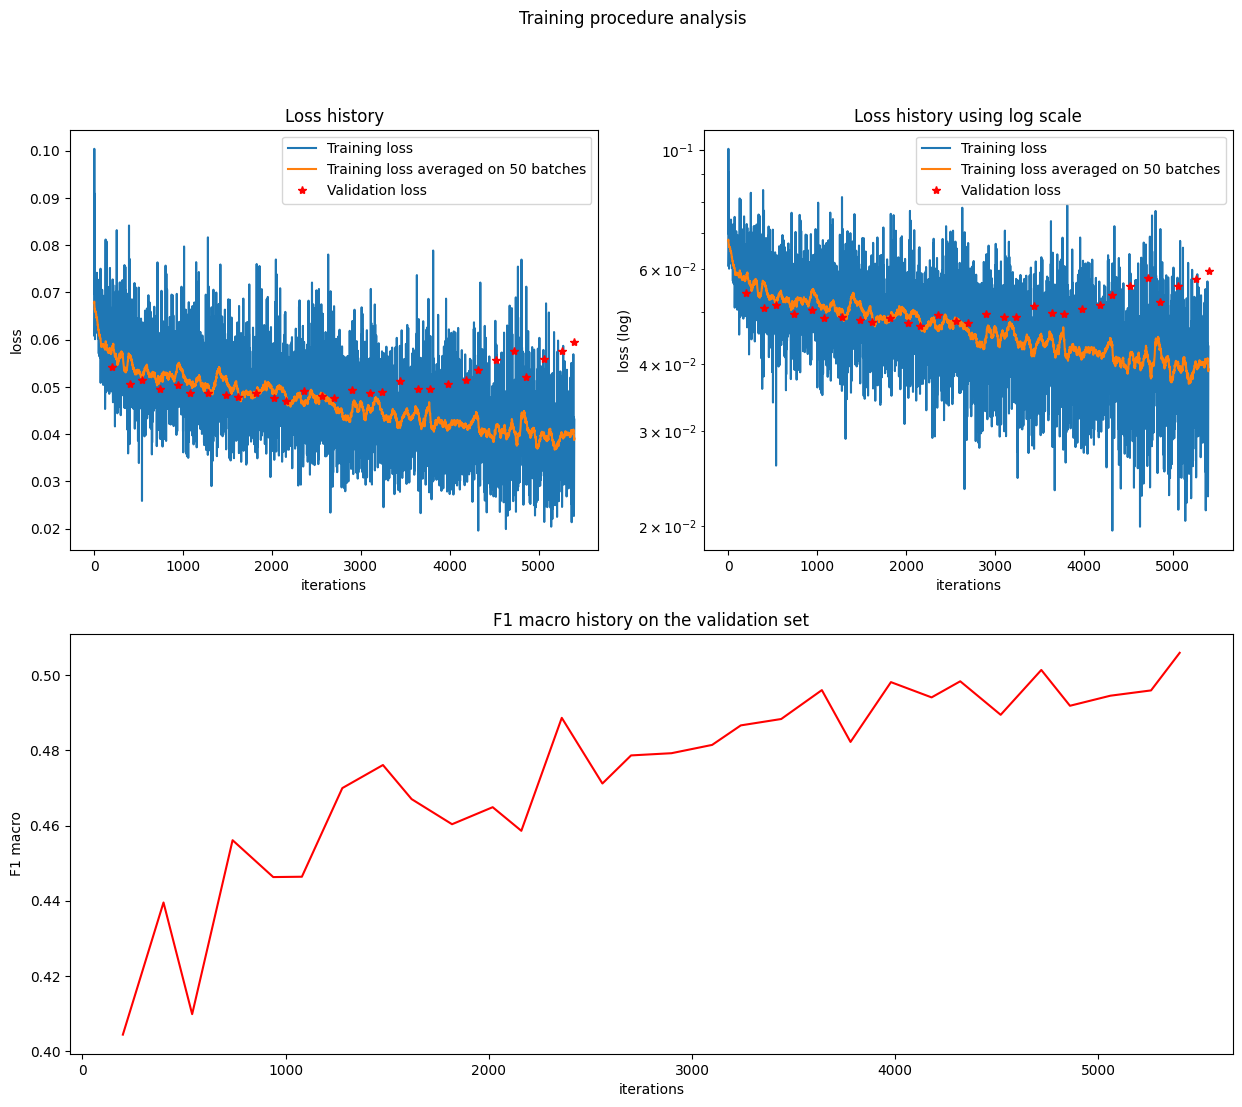

In [47]:
plot_training_history(np.array(train_loss_history), np.array(val_loss_history), np.array(val_f1_macro_history))

In [48]:
preds, y_true = get_dataset_predictons(val_loader)
preds= torch.tensor(preds)
y_true= torch.tensor(y_true)
idx = torch.argsort(preds,0)
s_preds = torch.gather(preds, 0, idx)
s_true = torch.gather(y_true, 0, idx)

In [49]:
c_positive=torch.cumsum(s_true,0)
c_negative=torch.cumsum(1-s_true,0)

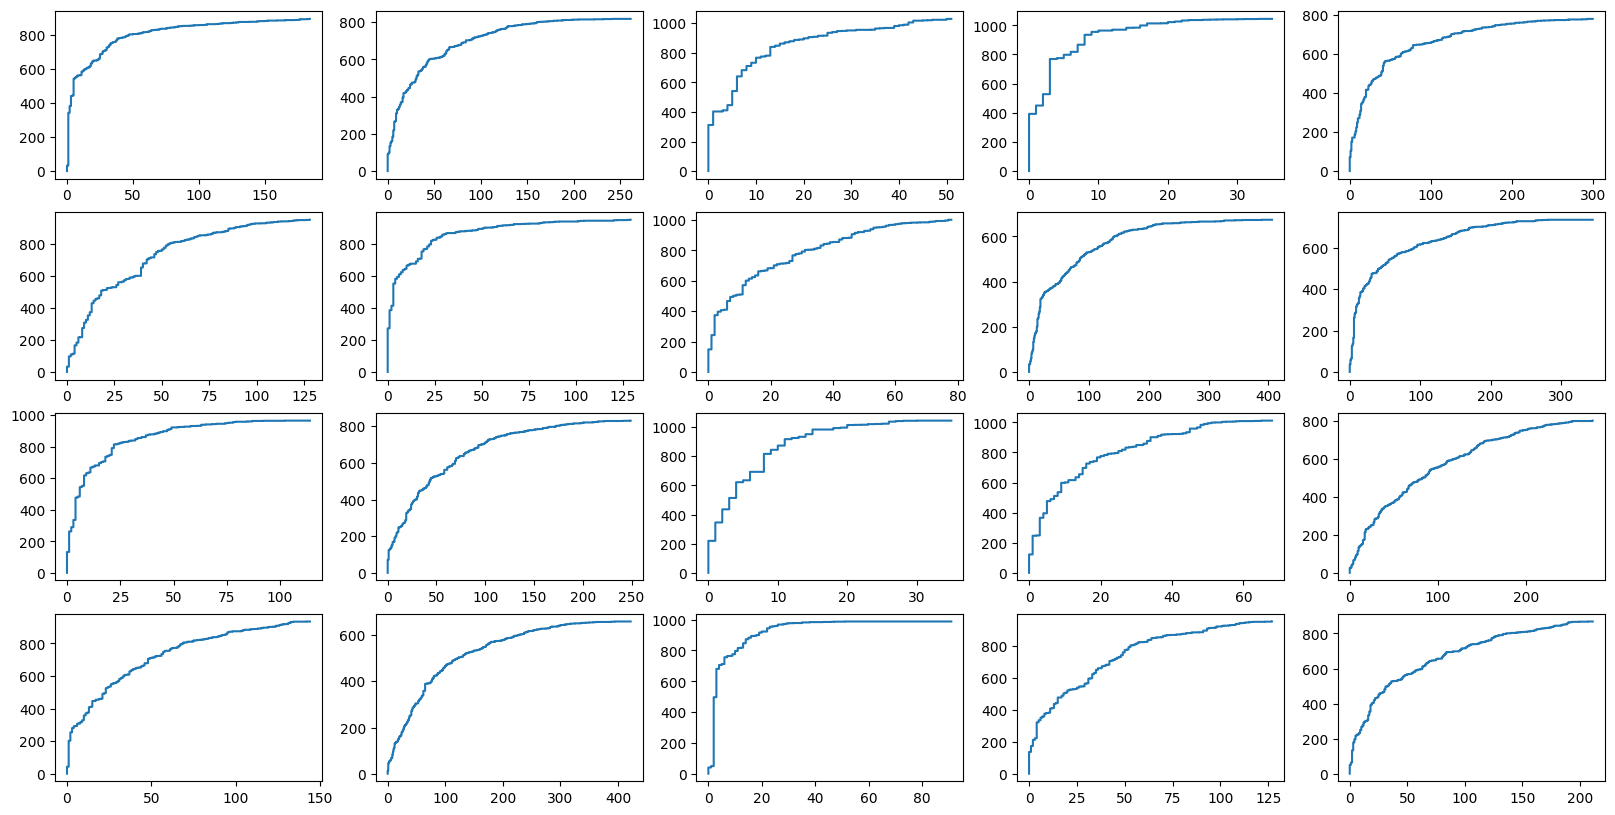

In [50]:
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(c_positive[:,i],c_negative[:,i])

In [51]:
c_true_positive = c_positive[-1:]-c_positive

R=(torch.arange(len(c_true_positive))+1)[:,None]
c_precision = (c_true_positive)/(R[-1]-R+1)+1e-7
c_recall = (c_true_positive)/(c_true_positive[:1]+1e-7)+1e-7
c_F1 = 2*(c_precision*c_recall)/(c_precision+c_recall)

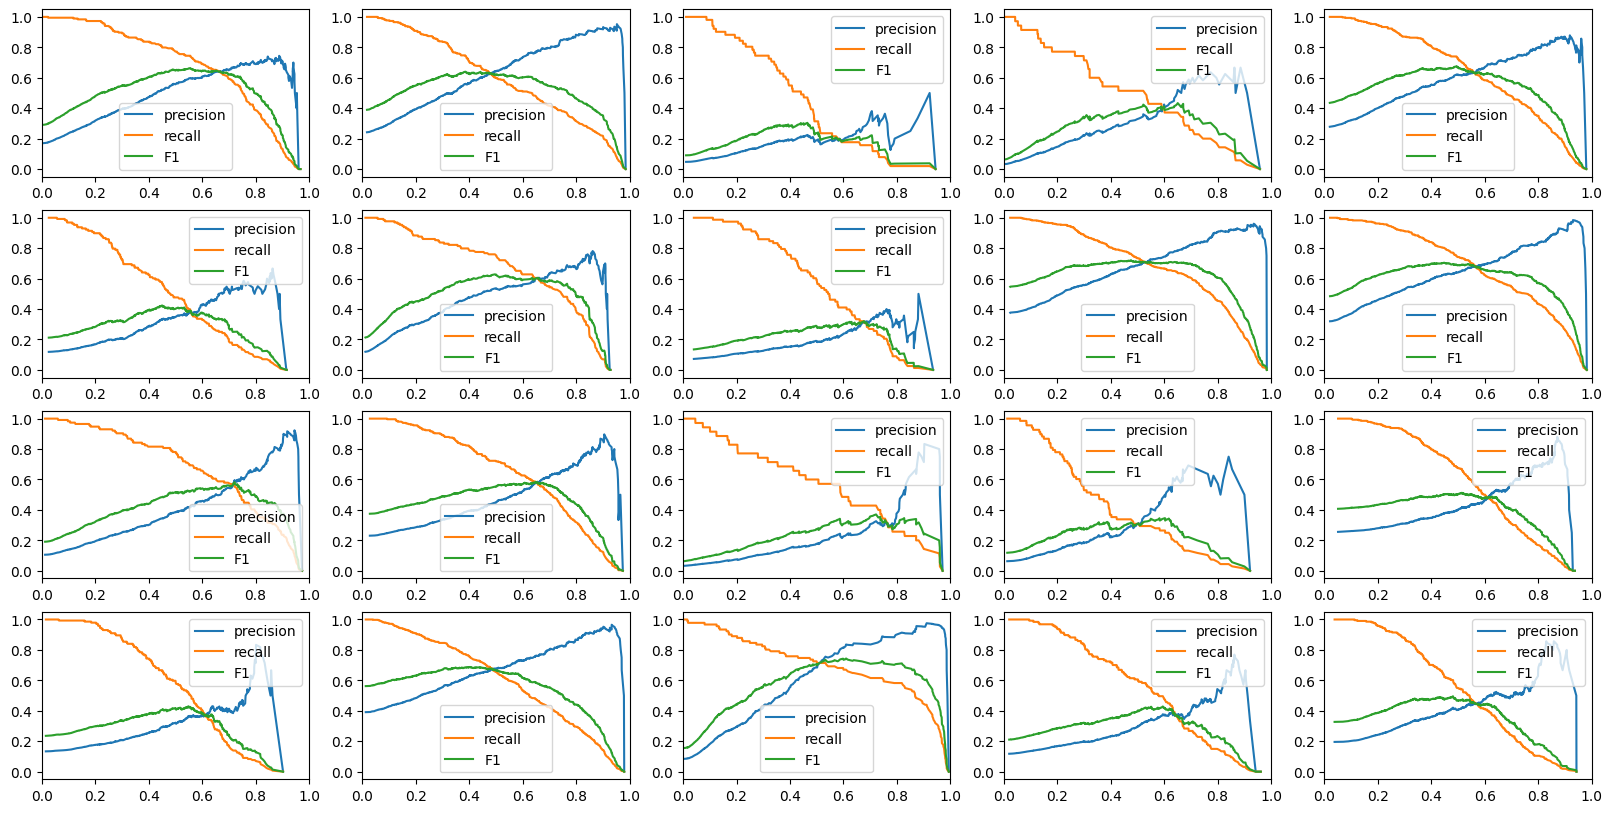

In [52]:
plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.plot(torch.sigmoid(s_preds[:,i]),c_precision[:,i],label='precision')
    plt.plot(torch.sigmoid(s_preds[:,i]),c_recall[:,i],label='recall')
    plt.plot(torch.sigmoid(s_preds[:,i]),c_F1[:,i], label='F1')
    plt.xlim(0,1)
    plt.legend()

In [53]:
idx_max = c_F1.argmax(0)
threshold=[s_preds[idx,i] for i, idx in enumerate(idx_max)]
threshold=np.array(threshold)

In [54]:
def predict(dataloader: DataLoader, threshold=None):
    preds, y_true = get_dataset_predictons(dataloader)
    if threshold is None:
        preds = preds > 0
    else:
        preds = preds > threshold
    preds = preds.astype(np.uint8)

    return preds, y_true

In [55]:
# Validation f1-score
from sklearn.metrics import f1_score

y_pred, y_true = predict(val_loader)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set: {f1_macro:.3f}')

Validation f1-score macro on the validation set: 0.506


In [56]:
# Validation f1-score + threshold
from sklearn.metrics import f1_score

y_pred, y_true = predict(val_loader, threshold)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Validation f1-score macro on the validation set with threshold selection: {f1_macro:.3f}')

Validation f1-score macro on the validation set with threshold selection: 0.537


In [57]:
from sklearn.metrics import classification_report

class_report_val = classification_report(y_true=y_true, y_pred=y_pred, target_names=labels_train_df.columns.to_list(),
                                     zero_division=0, output_dict=True)

print('Classification report for the validation set:')
print(classification_report(y_true=y_true, y_pred=y_pred,
                            target_names=labels_train_df.columns.to_list(), zero_division=0))

Classification report for the validation set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.60      0.74      0.67       184
    Self-direction: action       0.56      0.75      0.64       261
               Stimulation       0.23      0.47      0.31        51
                  Hedonism       0.54      0.37      0.44        35
               Achievement       0.62      0.74      0.68       300
          Power: dominance       0.33      0.58      0.42       128
          Power: resources       0.54      0.76      0.63       129
                      Face       0.32      0.32      0.32        78
        Security: personal       0.68      0.76      0.72       406
        Security: societal       0.63      0.80      0.71       345
                 Tradition       0.60      0.57      0.59       114
         Conformity: rules       0.58      0.59      0.59       249
 Conformity: interpersonal       0.33      0.43      0.38        35
 

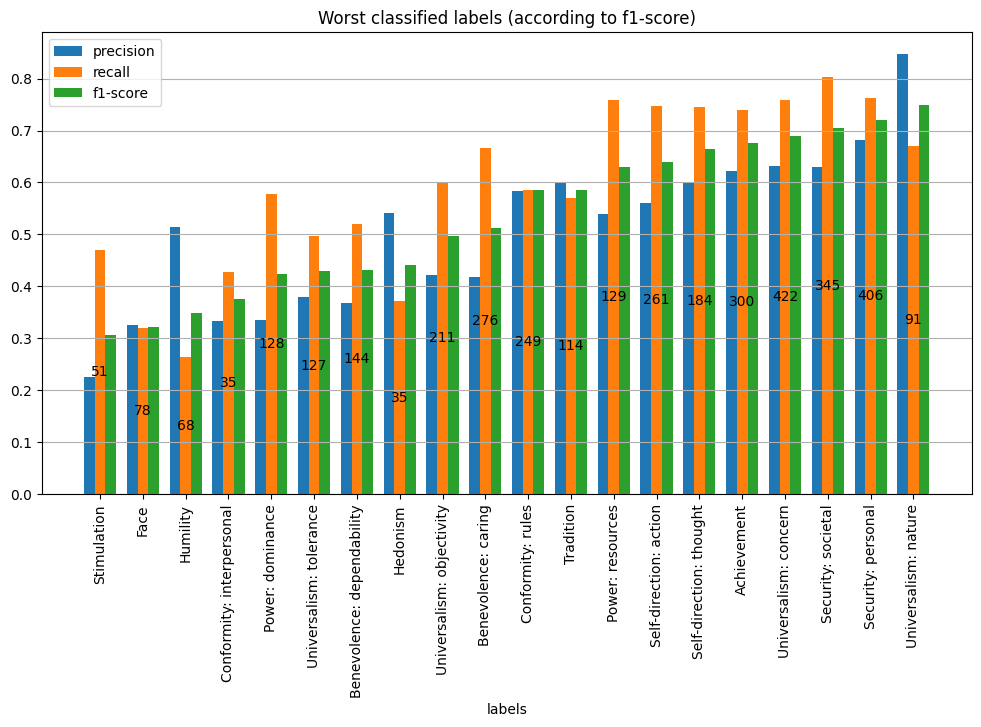

In [58]:
from typing import OrderedDict

class_report_sorted = sorted([(class_report_val[label]['f1-score'], label) 
                            for label in class_report_val.keys() if label in labels_train_df.columns.to_list() ])

class_report_sorted = OrderedDict({label:class_report_val[label] for (f1_score, label) in class_report_sorted})

plt.figure(figsize=(12,6))
x_axis = 2*np.arange(len(class_report_sorted))
plt.bar(x_axis-0.5, [class_report_sorted[tag]['precision'] for tag in class_report_sorted], label='precision', width=0.5)
b = plt.bar(x_axis, [class_report_sorted[tag]['recall'] for tag in class_report_sorted], label='recall', width=0.5)
plt.bar(x_axis+0.5, [class_report_sorted[tag]['f1-score'] for tag in class_report_sorted], label='f1-score', width=0.5)
plt.bar_label(b, labels=[class_report_sorted[tag]['support'] for tag in class_report_sorted], label_type='center')
plt.xticks(x_axis, list(class_report_sorted.keys()))
plt.grid(axis='y')
plt.legend()
plt.xticks(rotation=90)
plt.title('Worst classified labels (according to f1-score)')
plt.xlabel('labels')
plt.show()


In [59]:
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(y_true, y_pred).astype(np.float32)

#confusion_matrix[,:]confusion_matrix[,:] / confusion_matrix.astype(np.float).sum(axis=(0, 1))


In [60]:
from copy import deepcopy

def get_normalized_confusion_matrices(confusion_matrices: np.ndarray, normalize_by: str = 'recall'):
    assert normalize_by in ['recall', 'precision', 'accuracy'], \
        'Select one normalization metric among: recall, precision or accuracy'
    
    confusion_matrices = deepcopy(confusion_matrices)
    
    for i in range(confusion_matrices.shape[0]):
        if normalize_by == 'accuracy':
            confusion_matrices[i] = confusion_matrix[i] / confusion_matrix[i].sum()
        elif normalize_by == 'precision':
            confusion_matrices[i] = confusion_matrix[i] / confusion_matrix[i].sum(axis=0)
        elif normalize_by == 'recall':
            confusion_matrices[i] = confusion_matrix[i] / confusion_matrix[i].sum(axis=1, keepdims=True)

    return confusion_matrices
    

In [61]:
confusion_matrix_recall = get_normalized_confusion_matrices(confusion_matrix)

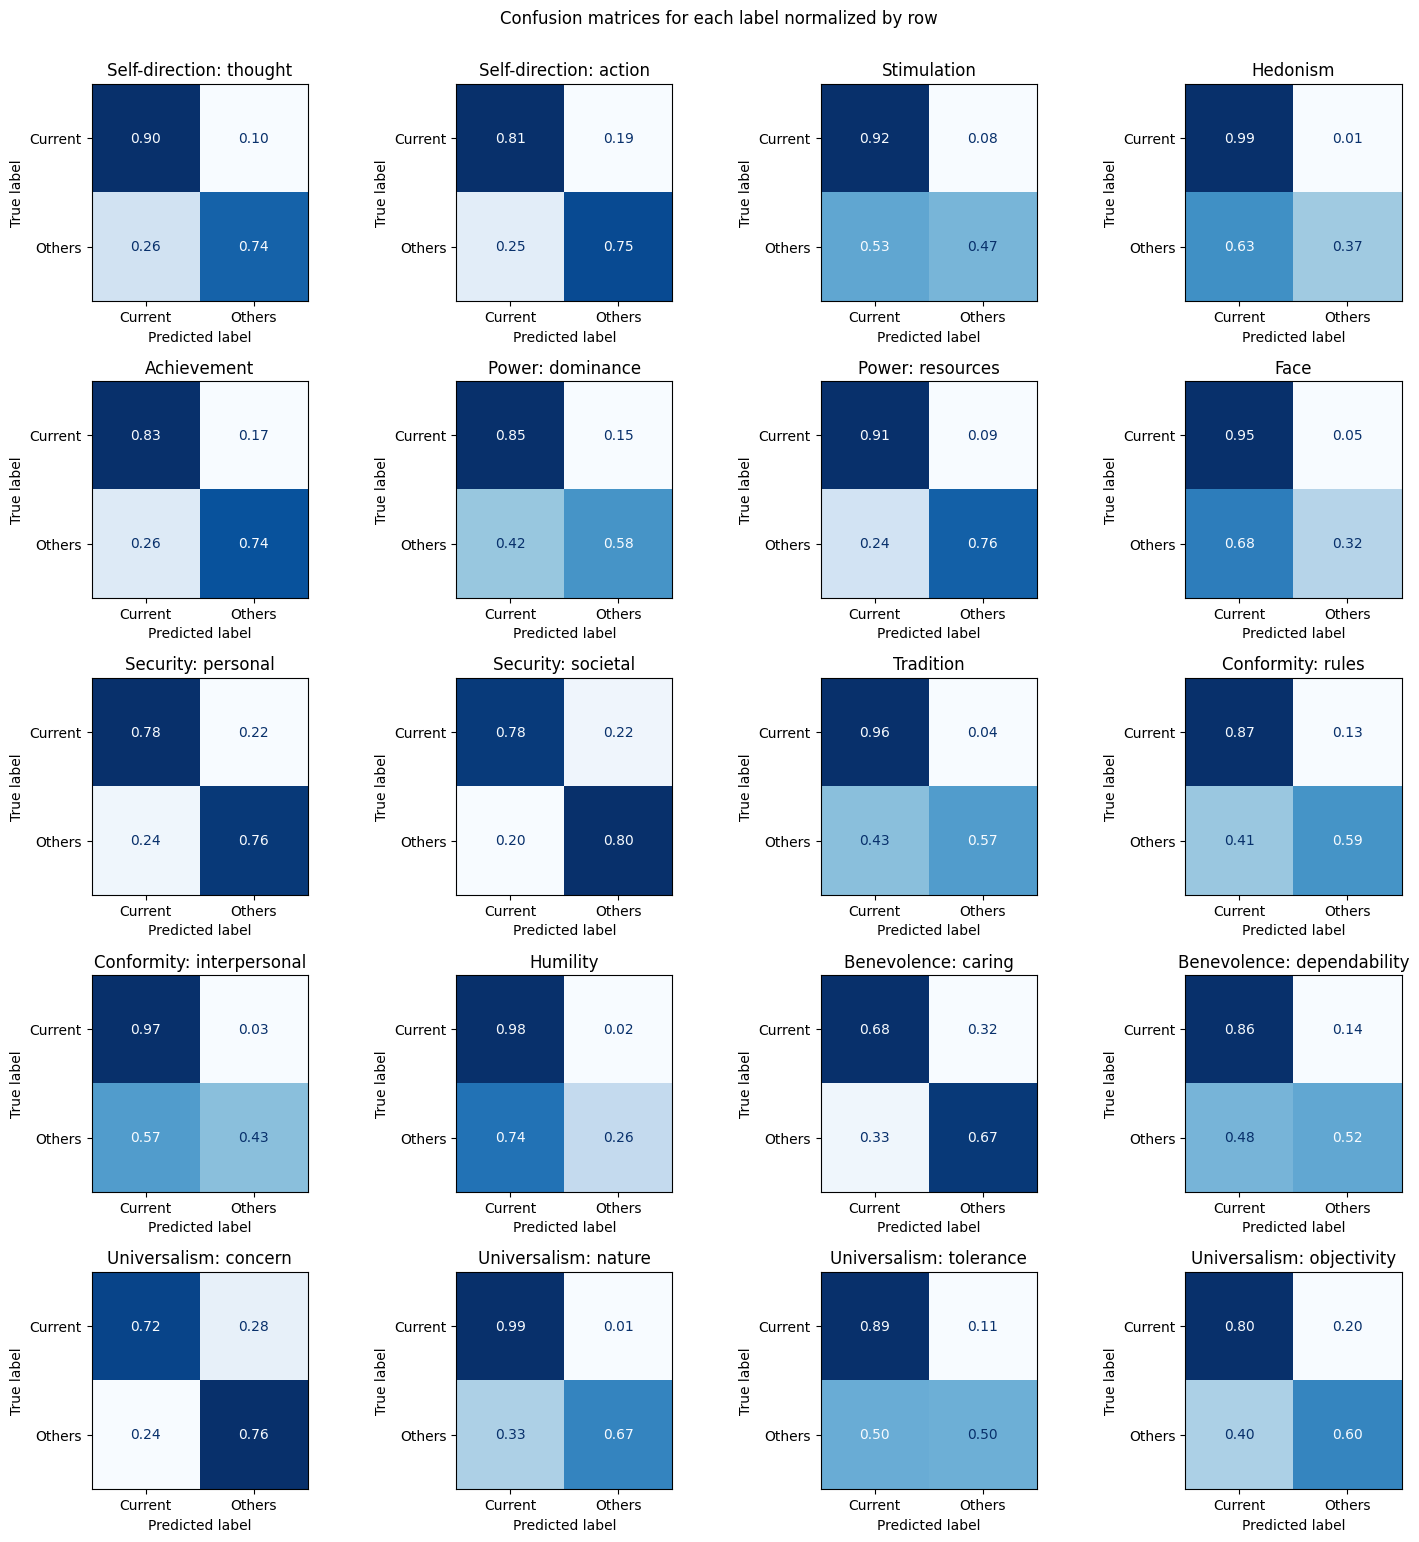

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(5, 4, figsize=(15, 15))

for i, (matrix, label) in enumerate(zip(confusion_matrix_recall, labels_train_df.columns.to_list())):
    ax = plt.subplot(5, 4, i + 1)
    cf = ConfusionMatrixDisplay(matrix, display_labels=['Current', 'Others'])
    cf.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax, colorbar=False)
    ax.set_title(label)
    
fig.tight_layout()

plt.suptitle('Confusion matrices for each label normalized by row', y=1.025)

plt.show()


In [63]:
preds, y_true = get_dataset_predictons(val_loader)

In [64]:
from sklearn.metrics import roc_curve, auc

threshold = 0



fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(labels_test_df.columns.to_list())):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(labels_test_df.columns.to_list())):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(labels_test_df.columns.to_list())

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.83


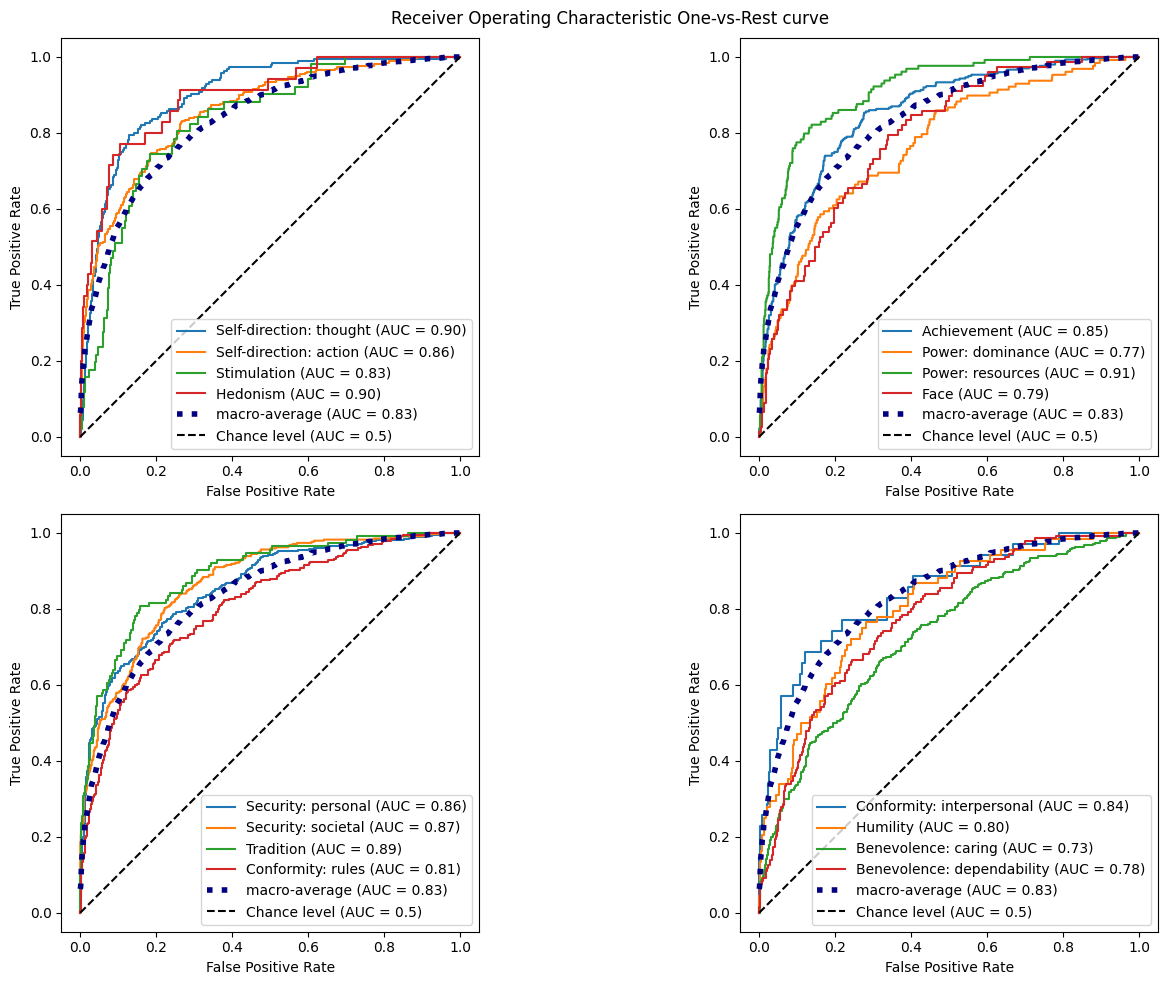

In [65]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

def _plot_roc_subplot(index, ax):
    ax = plt.subplot(2, 2, index + 1)

    for class_id in range(index * 4, index * 4 + 4):
        RocCurveDisplay.from_predictions(
            y_true[:, class_id],
            preds[:, class_id],
            name=f"{labels_test_df.columns.to_list()[class_id]}",
            ax=ax
        )

#fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.suptitle('Receiver Operating Characteristic One-vs-Rest curve')

for i in range(4):
    _plot_roc_subplot(i, ax)
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.axis("square")
plt.tight_layout()
plt.show()

In [66]:
from sklearn.metrics import f1_score

y_pred, y_true = predict(test_loader)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Test f1-score macro on the test set: {f1_macro:.3f}')

Test f1-score macro on the test set: 0.458


In [67]:
from sklearn.metrics import f1_score

y_pred, y_true = predict(test_loader, threshold)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Test f1-score macro on the test set with threshold selection: {f1_macro:.3f}')

Test f1-score macro on the test set with threshold selection: 0.458


In [68]:
from sklearn.metrics import classification_report

class_report_test = classification_report(y_true=y_true, y_pred=y_pred, target_names=labels_train_df.columns.to_list(),
                                     zero_division=0, output_dict=True)

print('Classification report for the test set:')
print(classification_report(y_true=y_true, y_pred=y_pred,
                            target_names=labels_train_df.columns.to_list(), zero_division=0))

Classification report for the test set:
                            precision    recall  f1-score   support

   Self-direction: thought       0.37      0.71      0.49       251
    Self-direction: action       0.61      0.52      0.56       496
               Stimulation       0.30      0.30      0.30       138
                  Hedonism       0.34      0.33      0.34       103
               Achievement       0.68      0.63      0.65       575
          Power: dominance       0.28      0.32      0.30       164
          Power: resources       0.43      0.70      0.53       132
                      Face       0.16      0.59      0.26       130
        Security: personal       0.74      0.77      0.76       759
        Security: societal       0.61      0.69      0.65       488
                 Tradition       0.28      0.56      0.38       172
         Conformity: rules       0.45      0.76      0.57       455
 Conformity: interpersonal       0.12      0.38      0.19        60
       

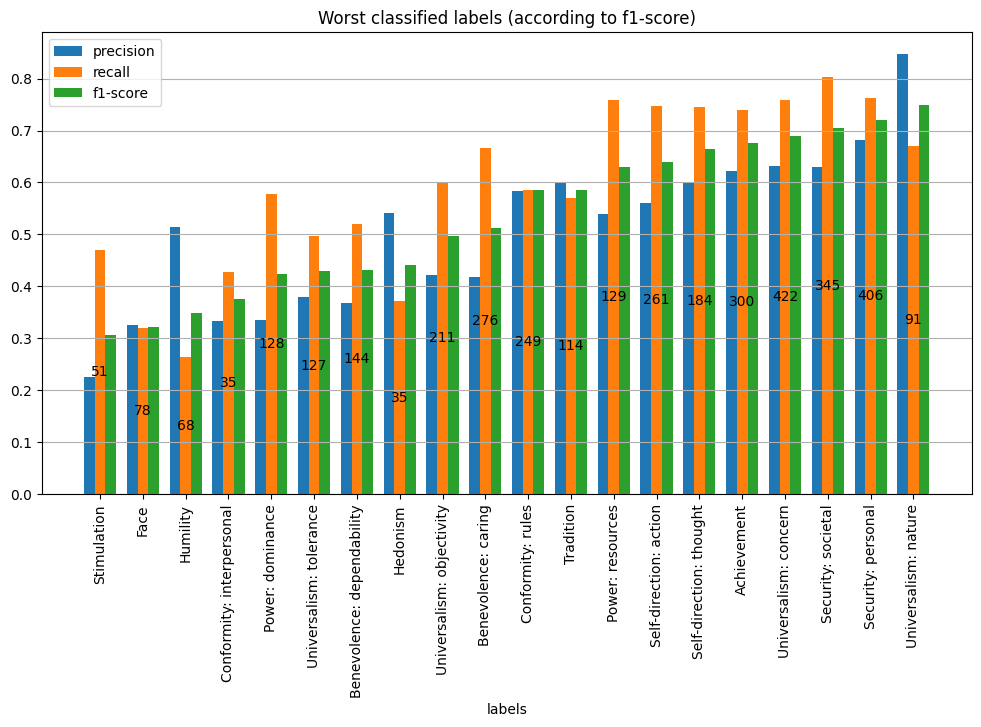

In [69]:
from typing import OrderedDict

class_report_sorted = sorted([(class_report_val[label]['f1-score'], label) 
                            for label in class_report_val.keys() if label in labels_train_df.columns.to_list() ])

class_report_sorted = OrderedDict({label:class_report_val[label] for (f1_score, label) in class_report_sorted})

plt.figure(figsize=(12,6))
x_axis = 2*np.arange(len(class_report_sorted))
plt.bar(x_axis-0.5, [class_report_sorted[tag]['precision'] for tag in class_report_sorted], label='precision', width=0.5)
b = plt.bar(x_axis, [class_report_sorted[tag]['recall'] for tag in class_report_sorted], label='recall', width=0.5)
plt.bar(x_axis+0.5, [class_report_sorted[tag]['f1-score'] for tag in class_report_sorted], label='f1-score', width=0.5)
plt.bar_label(b, labels=[class_report_sorted[tag]['support'] for tag in class_report_sorted], label_type='center')
plt.xticks(x_axis, list(class_report_sorted.keys()))
plt.grid(axis='y')
plt.legend()
plt.xticks(rotation=90)
plt.title('Worst classified labels (according to f1-score)')
plt.xlabel('labels')
plt.show()


In [70]:
confusion_matrix_recall = get_normalized_confusion_matrices(confusion_matrix)

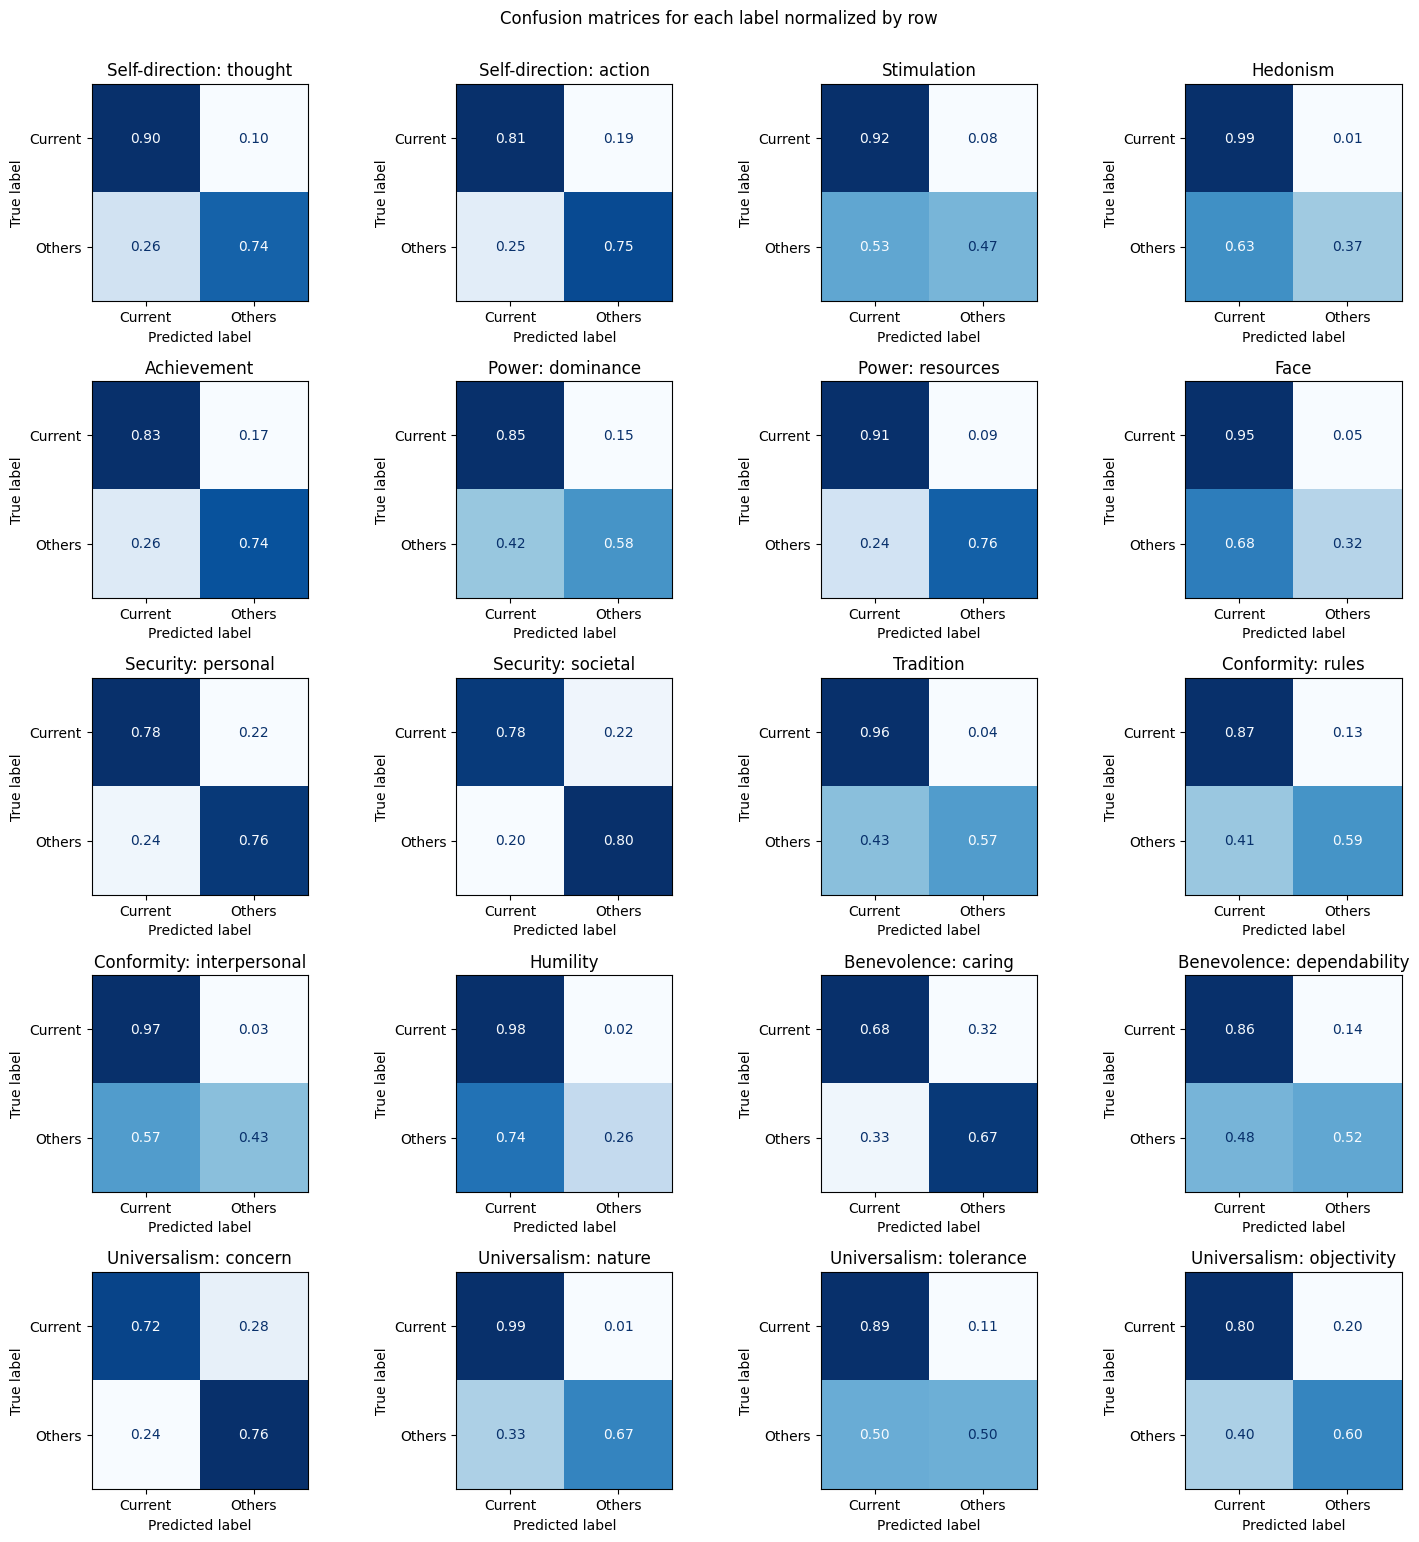

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(5, 4, figsize=(15, 15))

for i, (matrix, label) in enumerate(zip(confusion_matrix_recall, labels_train_df.columns.to_list())):
    ax = plt.subplot(5, 4, i + 1)
    cf = ConfusionMatrixDisplay(matrix, display_labels=['Current', 'Others'])
    cf.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax, colorbar=False)
    ax.set_title(label)
    
fig.tight_layout()

plt.suptitle('Confusion matrices for each label normalized by row', y=1.025)

plt.show()

In [72]:
preds, y_true = get_dataset_predictons(test_loader)

In [73]:
from sklearn.metrics import roc_curve, auc

threshold = 0



fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(len(labels_test_df.columns.to_list())):
    fpr[i], tpr[i], _ = roc_curve(y_true[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(labels_test_df.columns.to_list())):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(labels_test_df.columns.to_list())

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.79


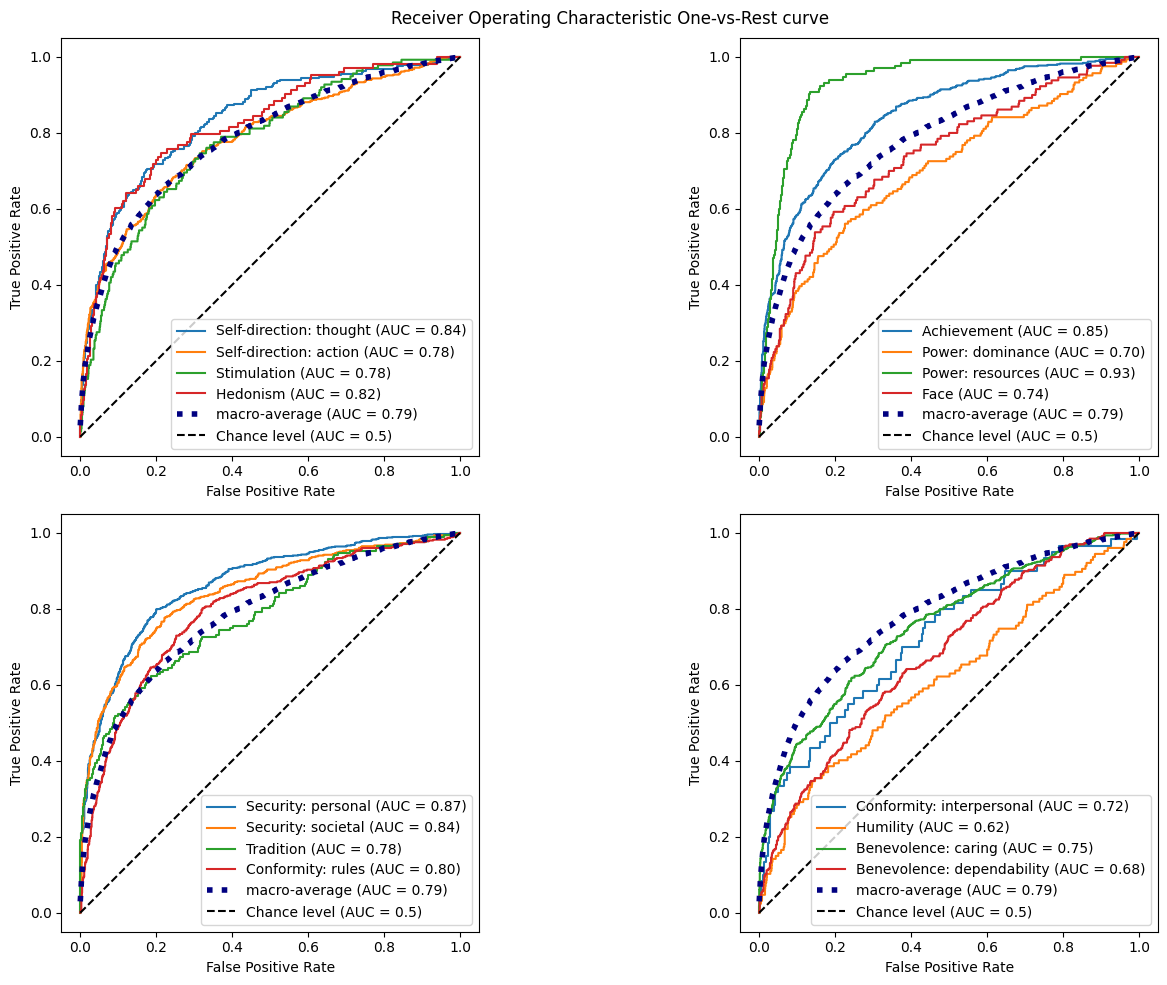

In [74]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay

def _plot_roc_subplot(index, ax):
    ax = plt.subplot(2, 2, index + 1)

    for class_id in range(index * 4, index * 4 + 4):
        RocCurveDisplay.from_predictions(
            y_true[:, class_id],
            preds[:, class_id],
            name=f"{labels_test_df.columns.to_list()[class_id]}",
            ax=ax
        )

#fig, ax = plt.subplots(2, 2, figsize=(15, 10))
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.suptitle('Receiver Operating Characteristic One-vs-Rest curve')

for i in range(4):
    _plot_roc_subplot(i, ax)
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    plt.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.axis("square")
plt.tight_layout()
plt.show()